In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
    !pip3 install pickle5 -q
    !apt-get install p7zip-full -q
    !7z x 'drive/MyDrive/Colab Notebooks/Project/FreiHAND_split.7z'
    !7z x 'drive/MyDrive/Colab Notebooks/Project/RHD_published_v2.zip'
    !cp 'drive/MyDrive/Colab Notebooks/Project/Networks.py' .
    !cp 'drive/MyDrive/Colab Notebooks/Project/HandDataset.py' .
    !cp 'drive/MyDrive/Colab Notebooks/Project/Rotations.py' .
    PATH = 'drive/MyDrive/Colab Notebooks/Project/'
except:
    IN_COLAB = False
    PATH = ''

Mounted at /content/drive
     |████████████████████████████████| 256 kB 6.5 MB/s 
Reading package lists...
Building dependency tree...
Reading state information...
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 484355643 bytes (462 MiB)

Extracting archive: drive/MyDrive/Colab Notebooks/Project/FreiHAND_split.7z
--
Path = drive/MyDrive/Colab Notebooks/Project/FreiHAND_split.7z
Type = 7z
Physical Size = 484355643
Headers Size = 412810
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      0% 7        0% 7 - FreiHAND_split/evaluation/color/00024420.jpg                          

In [2]:
if IN_COLAB:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Not connected to a GPU')
    else:
        print(gpu_info)

Sun Nov 28 18:44:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from importlib import reload
import torch.nn.functional as F

from HandDataset import *
from Networks import *

manualSeed = 42
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [4]:
batch_size = 32
img_size = 64
nc, nz = 3, 128 # number of channels in training images
ngf, ndf = 64, 64
num_epochs = 30
lr, beta1 = 0.0002, 0.5 # hyperparam for Adam optimizers
lmbda = 10
gamma = 0.3

In [5]:
synth_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    #transforms.Normalize((.5,.5,.5),(.5,.5,.5)) # (replace with actual mean and std)
])

real_transform = transforms.Compose([
    transforms.CenterCrop(112),
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((.5,.5,.5),(.5,.5,.5)) # (replace with actual mean and std)
])

synth_ds = HandDataset(
    img_dir='RHD_published_v2/training/color',
    mask_dir='RHD_published_v2/training/mask',
    anno_path='RHD_published_v2/training/anno_training.pickle',
    black_size=320,
    zfill=5,
    ext='.png',
    transform=synth_transform,
    masked=True,
    centered=True,
    coef = 2.2,
    normalise=True
)

real_ds = HandDataset(
    img_dir='FreiHAND_split/training/rgb',
    mask_dir='FreiHAND_split/training/mask',
    anno_path='FreiHAND_split/FreiHAND_anno_training.pickle', # incomplete (only contains xyz data)
    zfill=8,
    ext='.jpg',
    black_size=224,
    masked=True,
    transform=real_transform,
    normalise=False
)

In [6]:
synth_train,synth_test = random_split(synth_ds, [len(synth_ds)-64, 64])
real_train,real_test = random_split(real_ds, [len(real_ds)-64, 64])

In [7]:
synth_loader = DataLoader(synth_train, batch_size=batch_size, shuffle=True, drop_last=True)
real_loader = DataLoader(real_train, batch_size=batch_size, shuffle=True, drop_last=True)

synth_test_loader = DataLoader(synth_test, batch_size=64, shuffle=True, drop_last=True)
real_test_loader = DataLoader(real_test, batch_size=64, shuffle=True, drop_last=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
G_s2r = CycleGenerator(num_residuals=4).to(device)
G_s2r.apply(weights_init)

CycleGenerator(
  (initial): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), padding_mode=reflect)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down_blocks): ModuleList(
    (0): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (1): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
  )
  (res_blocks): Sequential(
    (0): Resid

In [9]:
G_r2s = CycleGenerator(num_residuals=4).to(device)
G_r2s.apply(weights_init)

CycleGenerator(
  (initial): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), padding_mode=reflect)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down_blocks): ModuleList(
    (0): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (1): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
  )
  (res_blocks): Sequential(
    (0): Resid

In [10]:
D_real = PatchDiscriminator(ndf=ndf).to(device)
D_real.apply(weights_init)

PatchDiscriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
  (conv4): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=reflect)
  (bn2): InstanceNorm2d(128, eps=1e-05, momentum=0.9, affine=False, track_running_stats=False)
  (bn3): InstanceNorm2d(256, eps=1e-05, momentum=0.9, affine=False, track_running_stats=False)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (bn_fc): BatchNorm1d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (FC1): Linear(in_features=16384, out_features=512, bias=False)
  (FC2): Linear(in_features=512, out_features=66, bias=True)
  (activ): LeakyReLU(negative_slope=

In [11]:
D_synth = PatchDiscriminator(ndf=ndf).to(device)
D_synth.apply(weights_init)

PatchDiscriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
  (conv4): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=reflect)
  (bn2): InstanceNorm2d(128, eps=1e-05, momentum=0.9, affine=False, track_running_stats=False)
  (bn3): InstanceNorm2d(256, eps=1e-05, momentum=0.9, affine=False, track_running_stats=False)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (bn_fc): BatchNorm1d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (FC1): Linear(in_features=16384, out_features=512, bias=False)
  (FC2): Linear(in_features=512, out_features=66, bias=True)
  (activ): LeakyReLU(negative_slope=

In [12]:
opt_D = optim.Adam(
    list(D_real.parameters()) + list(D_synth.parameters()),
    lr=lr,
    betas=(0.5,0.999)
)

opt_G = optim.Adam(
    list(G_s2r.parameters()) + list(G_r2s.parameters()),
    lr=lr,
    betas=(0.5,0.999)
)

L1 = nn.L1Loss()
mse = nn.MSELoss()

In [13]:
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

epoch = 0
iters = 0

In [14]:
class ReplayBuffer:
    def __init__(self, max_size=256):
        assert max_size > 0, "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return torch.cat(to_return)

In [15]:
fake_real_buffer = ReplayBuffer()
fake_synth_buffer = ReplayBuffer()

D_losses = []
G_losses = []

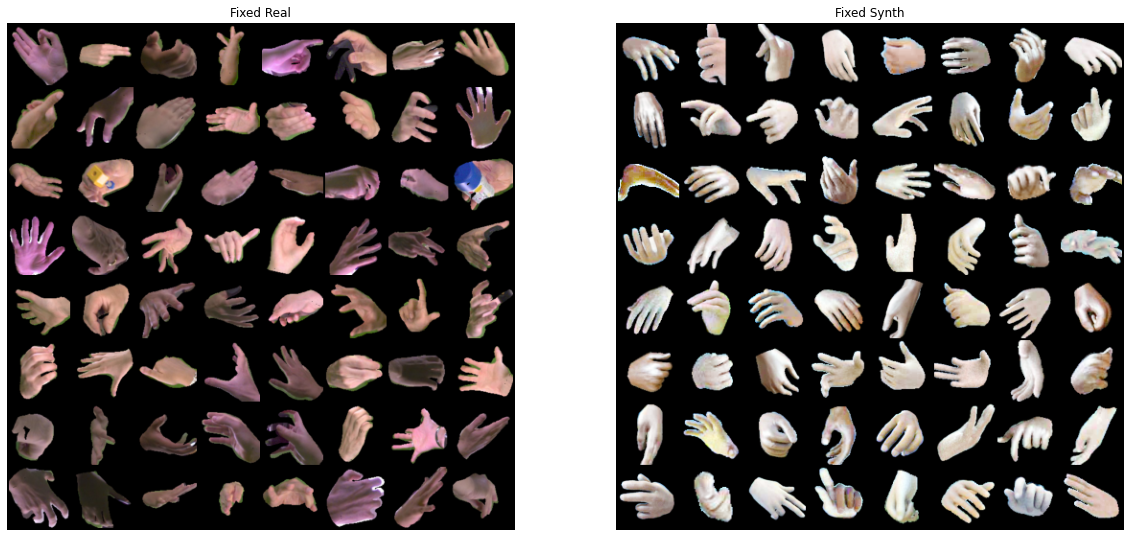

In [16]:
fixed_real = next(iter(real_test_loader))[0][:64].to(device)
fixed_synth = next(iter(synth_test_loader))[0][:64].to(device)

plt.figure(figsize=(20,40))
ax = plt.subplot(2,2,1)
plt.axis('off')
plt.title('Fixed Real')
plt.imshow(np.transpose(vutils.make_grid(fixed_real[:64],
                                        padding=2, normalize=True).cpu(),(1,2,0)))

ax = plt.subplot(2,2,2)
plt.axis('off')
plt.title('Fixed Synth')
plt.imshow(np.transpose(vutils.make_grid(fixed_synth[:64],
                                        padding=2, normalize=True).cpu(),(1,2,0)))

In [17]:
print("Starting Training Loop...")

while epoch < num_epochs:
    synth_loader_iterator = iter(synth_loader)
    for i, real_batch in enumerate(real_loader):
        try:
            synth_batch = next(synth_loader_iterator)
        except StopIteration:
            synth_loader_iterator = iter(synth_loader)
            synth_batch = next(synth_loader_iterator)

        real = real_batch[0].to(device)
        real_xyz = real_batch[1].view(-1,66).type(torch.half).to(device)
        synth = synth_batch[0].to(device)
        synth_xyz = synth_batch[1].view(-1,66).type(torch.half).to(device)

        # Train discriminators
        with torch.cuda.amp.autocast():
            new_real_hat = G_s2r(synth)
            real_hat = fake_real_buffer.push_and_pop(new_real_hat)

            D_R_real,_ = D_real(real)
            D_R_fake,_ = D_real(real_hat.detach())
            D_R_real_loss = mse(D_R_real, torch.ones_like(D_R_real))
            D_R_fake_loss = mse(D_R_fake, torch.zeros_like(D_R_fake))
            # D_R_real_xyz_loss = mse(D_R_real_xyz, real_xyz)
            # D_R_fake_xyz_loss = mse(D_R_fake_xyz, real_xyz)
            D_R_loss = D_R_real_loss + D_R_fake_loss
            # D_R_xyz_loss = D_R_real_xyz_loss + D_R_fake_xyz_loss

            new_synth_hat = G_r2s(real)
            synth_hat = fake_synth_buffer.push_and_pop(new_synth_hat)
            
            D_S_real,_ = D_synth(synth)
            D_S_fake,_ = D_synth(synth_hat.detach())
            D_S_real_loss = mse(D_S_real, torch.ones_like(D_S_real))
            D_S_fake_loss = mse(D_S_fake, torch.zeros_like(D_S_fake))
            # D_S_real_xyz_loss = mse(D_S_real_xyz, synth_xyz)
            # D_S_fake_xyz_loss = mse(D_S_fake_xyz, synth_xyz)
            D_S_loss = D_S_real_loss + D_S_fake_loss
            # D_S_xyz_loss = D_S_real_xyz_loss + D_S_fake_xyz_loss

            D_loss = (D_R_loss + D_S_loss)/2

        opt_D.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_D)
        d_scaler.update()

        # Train generators
        with torch.cuda.amp.autocast():
            D_R_fake,_ = D_real(real_hat)
            D_S_fake,_ = D_synth(synth_hat)
            loss_G_s2r = mse(D_R_fake, torch.ones_like(D_R_fake))
            loss_G_r2s = mse(D_S_fake, torch.ones_like(D_S_fake))
            # loss_G_s2r_xyz = mse(D_R_fake_xyz, synth_xyz)
            # loss_G_r2s_xyz = mse(D_S_fake_xyz, real_xyz)
            # loss_G_xyz = loss_G_s2r_xyz + loss_G_r2s_xyz

            #cycle loss
            D_R_real_layer = D_real(real)[1]
            D_S_real_layer = D_synth(synth)[1]

            cycle_synth = G_r2s(real_hat)
            cycle_real = G_s2r(synth_hat)

            _,D_R_cycle_layer = D_real(cycle_real)
            _,D_S_cycle_layer = D_synth(cycle_synth)

            # loss_D_S_cycle_xyz = mse(D_S_cycle_xyz, synth_xyz)
            # loss_D_R_cycle_xyz = mse(D_R_cycle_xyz, real_xyz)
            # loss_cycle_xyz = loss_D_S_cycle_xyz + loss_D_R_cycle_xyz

            cycle_synth_loss = L1(D_S_real_layer, D_S_cycle_layer)
            cycle_real_loss = L1(D_R_real_layer, D_R_cycle_layer)

            G_loss = (
                loss_G_s2r
                + loss_G_r2s
                + cycle_synth_loss * lmbda
                + cycle_real_loss * lmbda
                # + loss_G_xyz * gamma
                # + loss_cycle_xyz * gamma
            )

        opt_G.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_G)
        g_scaler.update()

        if iters % 50 == 0:
            G_losses.append(G_loss.item())
            D_losses.append(D_loss.item())
            print('[%d][%d/%d]\tLoss_D: %.3f\tLoss_G: %.3f'
                % (epoch, i, len(real_loader),
                    D_loss.item(), G_loss.item()))
            
        if iters % 1000 == 0:
            with torch.no_grad():
                plt.figure(figsize=(40,40))

                real_hat = G_s2r(fixed_synth)
                #img_list_synth2real.append(vutils.make_grid(real_hat, padding=2, normalize=True))
                ax = plt.subplot(2,2,1)
                plt.axis('off')
                plt.title('Synth to Real')
                plt.imshow(np.transpose(vutils.make_grid(real_hat[:64],
                                                        padding=2, normalize=True).cpu(),(1,2,0)))

                synth_hat_hat = G_r2s(real_hat)
                #img_list_real2synth.append(vutils.make_grid(x_hat, padding=2, normalize=True))
                ax = plt.subplot(2,2,2)
                plt.axis('off')
                plt.title('Real back to synth')
                plt.imshow(np.transpose(vutils.make_grid(synth_hat_hat[:64],
                                                        padding=2, normalize=True).cpu(),(1,2,0)))
                
                synth_hat = G_r2s(fixed_real)
                #img_list_synth2real.append(vutils.make_grid(real_hat, padding=2, normalize=True))
                ax = plt.subplot(2,2,3)
                plt.axis('off')
                plt.title('Real to synth')
                plt.imshow(np.transpose(vutils.make_grid(synth_hat[:64],
                                                        padding=2, normalize=True).cpu(),(1,2,0)))

                real_hat_hat = G_s2r(synth_hat)
                #img_list_real2synth.append(vutils.make_grid(x_hat, padding=2, normalize=True))
                ax = plt.subplot(2,2,4)
                plt.axis('off')
                plt.title('Synth back to real')
                plt.imshow(np.transpose(vutils.make_grid(real_hat_hat[:64],
                                                        padding=2, normalize=True).cpu(),(1,2,0)))
                plt.pause(0.01)

        iters += 1
    epoch += 1

Output hidden; open in https://colab.research.google.com to view.

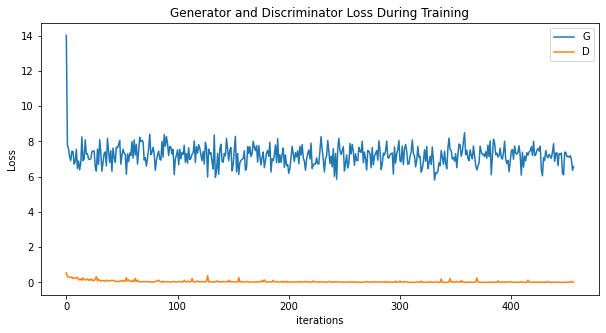

In [18]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [19]:
torch.save(D_real.state_dict(), PATH+'models/cyclegan_disc/D_real_27_11_21_epoch_{}.pth'.format(epoch))
torch.save(G_s2r.state_dict(), PATH+'models/cyclegan_disc/G_s2r_27_11_21_epoch_{}.pth'.format(epoch))